In [2]:
import matplotlib.pyplot as plt
import numpy as np
from cvxopt import matrix, solvers
from tqdm.auto import tqdm

### Question 18 ###

In [16]:
def compute_transition_probabilities(weight):
    prob_up = np.zeros((100, 100))
    prob_down = np.zeros((100, 100))
    prob_left = np.zeros((100, 100))
    prob_right = np.zeros((100, 100))

    for index in range(100):
        if index % 10 == 0:
            prob_up[index][index] += weight / 4
            prob_down[index][index] += weight / 4
            prob_left[index][index] += weight / 4
            prob_right[index][index] += weight / 4
        else:
            prob_up[index][index - 1] = 1 - weight + weight / 4
            prob_down[index][index - 1] = weight / 4
            prob_left[index][index - 1] = weight / 4
            prob_right[index][index - 1] = weight / 4

        if index - 10 < 0:
            prob_up[index][index] += weight / 4
            prob_down[index][index] += weight / 4
            prob_left[index][index] += weight / 4
            prob_right[index][index] += weight / 4
        else:
            prob_up[index][index - 10] = weight / 4
            prob_down[index][index - 10] = weight / 4
            prob_left[index][index - 10] = 1 - weight + weight / 4
            prob_right[index][index - 10] = weight / 4

        if index + 10 > 99:
            prob_up[index][index] += weight / 4
            prob_down[index][index] += weight / 4
            prob_left[index][index] += weight / 4
            prob_right[index][index] += weight / 4
        else:
            prob_up[index][index + 10] = weight / 4
            prob_down[index][index + 10] = weight / 4
            prob_left[index][index + 10] = weight / 4
            prob_right[index][index + 10] = 1 - weight + weight / 4

        if (index + 1) % 10 == 0:
            prob_up[index][index] += weight / 4
            prob_down[index][index] += weight / 4
            prob_left[index][index] += weight / 4
            prob_right[index][index] += weight / 4
        else:
            prob_up[index][index + 1] = weight / 4
            prob_down[index][index + 1] = 1 - weight + weight / 4
            prob_left[index][index + 1] = weight / 4
            prob_right[index][index + 1] = weight / 4

        if index % 10 == 0:
            prob_up[index][index] += 1 - weight
        if (index + 1) % 10 == 0:
            prob_down[index][index] += 1 - weight
        if index - 10 < 0:
            prob_left[index][index] += 1 - weight
        if index + 10 > 99:
            prob_right[index][index] += 1 - weight

    return prob_up, prob_down, prob_left, prob_right

def get_optimal_policy(weight, discount_factor, reward_matrix, convergence_threshold):
    transition_up, transition_down, transition_left, transition_right = compute_transition_probabilities(weight)
    state_values = np.zeros(100)
    change = np.inf
    reward_vector = reward_matrix.T.ravel()

    while change > convergence_threshold:
        change = 0
        previous_state_values = np.copy(state_values)
        for state in range(100):
            val_up = np.sum(transition_up[state] * (reward_vector + discount_factor * previous_state_values))
            val_down = np.sum(transition_down[state] * (reward_vector + discount_factor * previous_state_values))
            val_left = np.sum(transition_left[state] * (reward_vector + discount_factor * previous_state_values))
            val_right = np.sum(transition_right[state] * (reward_vector + discount_factor * previous_state_values))
            state_values[state] = max(val_up, val_down, val_left, val_right)
            change = max(change, abs(previous_state_values[state] - state_values[state]))

    direction_arrows = [u"\u2191", u"\u2193", u"\u2190", u"\u2192"]
    optimal_strategy = []

    for state in range(100):
        val_up = np.sum(transition_up[state] * (reward_vector + discount_factor * state_values))
        val_down = np.sum(transition_down[state] * (reward_vector + discount_factor * state_values))
        val_left = np.sum(transition_left[state] * (reward_vector + discount_factor * state_values))
        val_right = np.sum(transition_right[state] * (reward_vector + discount_factor * state_values))
        values = [val_up, val_down, val_left, val_right]
        optimal_strategy.append(direction_arrows[values.index(max(values))])

    return np.array(optimal_strategy).reshape(10, 10).T

def compute_transition_and_reward_matrices(optimal_strategy, discount_factor, reward_maximum):
    direction_map = {u"\u2191": 0, u"\u2193": 1, u"\u2190": 2, u"\u2192":3}
    transition_matrices = list(compute_transition_probabilities(w))
    expected_transitions = []
    alternative_transitions = [[], [], []]

    for state_index in range(100):
        expected_action = direction_map[optimal_strategy[state_index]]
        alternative_index = 0
        for action_index in range(4):
            if action_index == expected_action:
                expected_transitions.append(transition_matrices[action_index][state_index])
            else:
                alternative_transitions[alternative_index].append(transition_matrices[action_index][state_index])
                alternative_index += 1

    expected_transitions = np.array(expected_transitions)
    identity_matrix = np.eye(100)
    zero_matrix = np.zeros((100, 100))
    concatenated_zeros = np.concatenate((zero_matrix, zero_matrix, zero_matrix, zero_matrix))
    stacked_matrices = np.concatenate(
        (concatenated_zeros, np.concatenate((-identity_matrix, -identity_matrix, zero_matrix, zero_matrix)), 
         np.concatenate((identity_matrix, -identity_matrix, identity_matrix, -identity_matrix))), 1)

    for alt_transitions in alternative_transitions:
        temp_matrix = np.dot(np.array(alt_transitions) - expected_transitions, 
                             np.linalg.inv(identity_matrix - discount_factor * expected_transitions))
        matrix_block1 = np.concatenate((identity_matrix, zero_matrix, temp_matrix), 1)
        matrix_block2 = np.concatenate((zero_matrix, zero_matrix, temp_matrix), 1)
        stacked_matrices = np.concatenate((np.concatenate((matrix_block1, matrix_block2)), stacked_matrices))

    constraint_vector = np.concatenate([np.zeros(800), reward_maximum * np.ones(200)])
    return matrix(stacked_matrices), matrix(constraint_vector)

def compute_coefficients(lambda_value):
    coefficients_negative = np.full(100, -1.0)
    coefficients_lambda = np.full(100, lambda_value)
    coefficients_zero = np.zeros(100)
    return matrix(np.concatenate((coefficients_negative, coefficients_lambda, coefficients_zero), axis=0))

def compute_lp_rewards(coefficients, matrix_D, vector_b):
    solvers.options["show_progress"] = False
    solution = solvers.lp(coefficients, matrix_D, vector_b)
    return np.array(solution["x"][-100:])

def evaluate_accuracy_over_lambdas(lambdas, strategy, discount_factor, max_reward, plot_title):
    identity_matrix = np.identity(100)
    accuracies = []

    D_matrix, b_vector = compute_transition_and_reward_matrices(strategy, discount_factor, max_reward)

    for lambda_value in tqdm(lambdas):
        coefficients = compute_coefficients(lambda_value)
        rewards = compute_lp_rewards(coefficients, D_matrix, b_vector)
        computed_policy = get_optimal_policy(w, discount_factor, rewards, epsilon)
        computed_policy_flattened = computed_policy.T.flatten()
        accuracy = (computed_policy_flattened == strategy).mean()
        accuracies.append(accuracy)

    plt.plot(lambdas, accuracies)
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.title(plot_title)
    plt.show()

    return accuracies

100%|██████████| 501/501 [02:09<00:00,  3.87it/s]


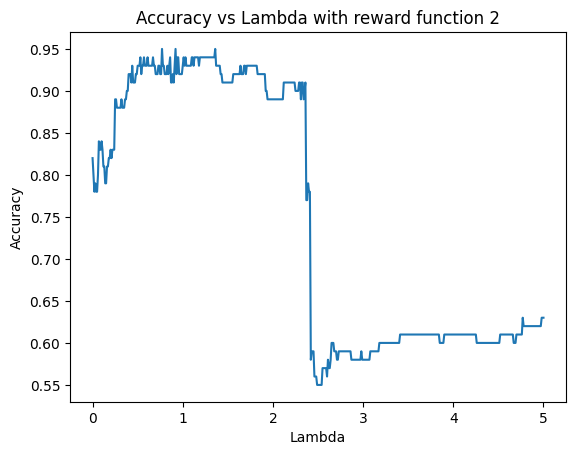

In [35]:
w = 0.1
gamma = 0.8
epsilon = 0.01
lambdas = np.arange(0, 5.01, 0.01)
reward_func2 = np.array([
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, -100, -100, -100, 0, 0, 0],
                   [0, 0, 0, 0, -100, 0, -100, 0, 0, 0],
                   [0, 0, 0, 0, -100, 0, -100, -100, -100, 0],
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0],
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0],
                   [0, 0, 0, 0, -100, 0, 0, 0, -100, 0],
                   [0, 0, 0, 0, 0, 0, -100, -100, -100, 0],
                   [0, 0, 0, 0, 0, 0, -100, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 10]
])

optimal_policy = get_optimal_policy(w, gamma, reward_func2, epsilon)
optimal_policy = optimal_policy.T.flatten()

r_max = abs(reward_func2).max()
title = "Accuracy vs Lambda with reward function 2"
accs = evaluate_accuracy_over_lambdas(lambdas, optimal_policy, gamma, r_max, title)

### Question 19 ###

In [36]:
max_accuracy_index = np.argmax(accs)
max_accuracy = accs[max_accuracy_index]
lambda_max2 = lambdas[max_accuracy_index]

print("Max accuracy:", max_accuracy)
print("λ(2)max:", lambda_max2)

Max accuracy: 0.95
λ(2)max: 0.77


### Question 20 ###

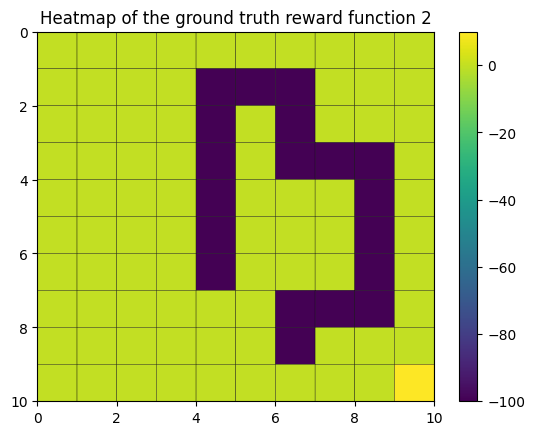

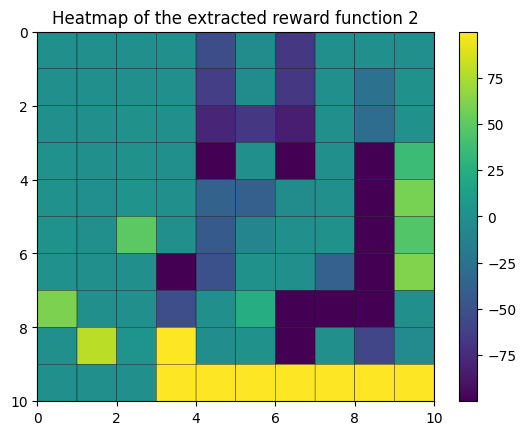

In [37]:
def plot_heatmap(grid, title):
    plt.pcolor(grid, edgecolors="black")
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.title(title)
    plt.show()
D, b = compute_transition_and_reward_matrices(optimal_policy, gamma, r_max)
c = compute_coefficients(lambda_max2)
rewards = compute_lp_rewards(c, D, b)
rewards = rewards.reshape(10,10).T
plot_heatmap(reward_func2, "Heatmap of the ground truth reward function 2")
plot_heatmap(rewards, "Heatmap of the extracted reward function 2")

### Question 21 ###

Number of steps to converge: 43


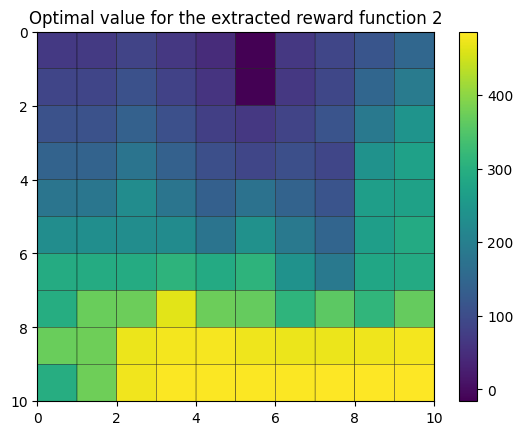

In [40]:
def get_state_value_snapshots(weight, discount_factor, reward_matrix, convergence_threshold):
    """
    Computes snapshots of state values during the convergence process of value iteration.

    :param weight: Weight factor used in transition probability calculations.
    :param discount_factor: Discount factor used in value iteration.
    :param reward_matrix: 2D array of reward values for each state.
    :param convergence_threshold: Convergence threshold for the value iteration algorithm.
    :return: List of snapshots of state values at each iteration until convergence.
    """
    # Compute transition probabilities
    transition_up, transition_down, transition_left, transition_right = compute_transition_probabilities(weight)
    state_values = np.zeros(100)
    change = np.inf
    reward_vector = reward_matrix.T.ravel()
    iterations = 0
    snapshots = []

    while change > convergence_threshold:
        change = 0
        previous_state_values = np.copy(state_values)
        action_values = [
            np.sum(tp * (reward_vector + discount_factor * previous_state_values), axis=1)
            for tp in [transition_up, transition_down, transition_left, transition_right]
        ]
        state_values = np.max(action_values, axis=0)
        change = np.max(np.abs(state_values - previous_state_values))

        iterations += 1
        snapshots.append(state_values.reshape(10, 10).T)

    print(f"Number of steps to converge: {iterations}")
    return snapshots

snapshots = get_state_value_snapshots(w, gamma, rewards, epsilon)
plot_heatmap(snapshots[-1], "Optimal value for the extracted reward function 2")

### Question 22 ###

Answer: Both scenarios exhibit a common pattern where the highest optimal values are located at state 99, with the values generally decreasing from the bottom right towards other parts of the map. However, there are notable differences in how these values are distributed and the scale of values across the heatmaps. The ground truth heatmap shows a value decay that progresses from the bottom right to the top left, aligning with the configuration of the reward function which features a singular high-reward state at this position. Conversely, the extracted heatmap displays a different decay pattern, where values diminish predominantly from bottom to top. This variation can be attributed to the differences in the reward structures: unlike the single high-reward focus in the ground truth, the extracted reward function shows multiple high-reward states along the last row, thus altering the gradient of decay to a more vertical orientation.

### Question 23 ###

In [42]:
optimal_policy = get_optimal_policy(w, gamma, rewards, epsilon)
optimal_policy

array([['↓', '↓', '↓', '←', '←', '→', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↑', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↑', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↓', '→', '→'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '←', '→', '→'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '↓', '↓', '↓'],
       ['→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '↓', '←', '→', '↓', '→', '↓']], dtype='<U1')

### Question 24 ###

Answer:The overall accuracy between the two policies is quite high at 95%, indicating significant similarity with only five distinct actions between them. Upon examining these discrepancies, it appears that four additional local optimal points emerge in the extracted policy. These variations are attributed to the extracted reward function assigning higher values at states 49, 79, 94, and 96 compared to their adjacent states. Consequently, the optimal actions at these specific states deviate from the strategy of moving towards state 99, as the local incentives guide decisions towards maximizing immediate rewards.

### Question 25 ###

In [45]:
# Compute the optimal policy using the ground truth reward function
ground_truth_policy = get_optimal_policy(w, gamma, reward_func2, convergence_threshold=0.01)
print(ground_truth_policy)

# Set a very small epsilon for high precision in the extracted policy calculation
fine_tuned_epsilon = 0.00001
extracted_policy = get_optimal_policy(w, gamma, rewards, fine_tuned_epsilon)

# Calculate and print the accuracy between the ground truth and extracted policies
policy_accuracy = (ground_truth_policy == extracted_policy).mean()
print("Accuracy after modification:", policy_accuracy)

# Optionally, display the extracted policy
extracted_policy


[['↓' '↓' '↓' '←' '←' '→' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↑' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '→' '→' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '↑' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '↓' '→' '↓']
 ['↓' '↓' '↓' '←' '←' '↓' '↓' '←' '→' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '←' '←' '→' '↓']
 ['↓' '↓' '↓' '↓' '↓' '↓' '←' '↓' '↓' '↓']
 ['→' '→' '→' '↓' '↓' '↓' '↓' '↓' '↓' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']]
Accuracy after modification: 1.0


array([['↓', '↓', '↓', '←', '←', '→', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↑', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '→', '→', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↑', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '↓', '→', '↓'],
       ['↓', '↓', '↓', '←', '←', '↓', '↓', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '←', '→', '↓'],
       ['↓', '↓', '↓', '↓', '↓', '↓', '←', '↓', '↓', '↓'],
       ['→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓'],
       ['→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']], dtype='<U1')

Answer: The plots clearly reveal two main discrepancies between the policies. The first discrepancy is observed in the last column, particularly at states 94 and 96, where the extracted rewards are significantly higher. This results in the optimal action being to remain at the current state, rather than moving. The second discrepancy appears in the last row, where the rewards of adjacent states are so similar that the optimal actions become susceptible to minor variations or noise in the data.

To address these issues, we refined the convergence criterion by reducing the threshold to 0.00001, thereby imposing a stricter requirement for convergence. This adjustment significantly enhanced the accuracy, achieving a perfect score of 1.0 and resolving both identified discrepancies.